# MAP 536 - Python for Data Science - Predicting Cyclist Traffic in Paris

### Adding External Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

In [2]:
## + Weather data
# Load training and testing datasets & remove unnecessary cols
train_data = pd.read_parquet("train.parquet")
test_data = pd.read_parquet("final_test.parquet")
train_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)
test_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)

#Load weather dataset and remove irrelevant columns
weather_data = pd.read_csv("hourly-weather-data.csv")
weather_data = weather_data.drop(columns=['name', 'dew', 'preciptype','uvindex','icon','stations', 'sealevelpressure', 'winddir', 'sealevelpressure', 'solarradiation', 'solarenergy', 'severerisk'])

# convert to datetime to merge them properly
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

#merge with weather data
merged_train_data = pd.merge(train_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_test_data = pd.merge(test_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_train_data = merged_train_data.drop(columns=['datetime'])
merged_test_data = merged_test_data.drop(columns=['datetime'])


## School Holidays + Weather data
# import the holiday dataset
schoolholiday_data = pd.read_csv("fr-calendrier.csv", delimiter=';')
schoolholiday_data = schoolholiday_data[schoolholiday_data['zones'] == 'Zone C'] # Zone C is Paris
schoolholiday_data = schoolholiday_data.drop(columns=['description','location','annee_scolaire', 'zones'])

# Convert the date strings to datetime objects
schoolholiday_data['start_date'] = pd.to_datetime(schoolholiday_data['start_date'], utc=True).dt.date
schoolholiday_data['end_date'] = pd.to_datetime(schoolholiday_data['end_date'],utc=True).dt.date

# Generate a set of unique dates for each range in a row
unique_dates = set()
for _, row in schoolholiday_data.iterrows():
    unique_dates.update(pd.date_range(start=row['start_date'], end=row['end_date']))

# Convert the set back to a list and create a DataFrame
unique_dates_list = sorted(list(unique_dates)) 
schoolholiday_data = pd.DataFrame({'Date': unique_dates_list})

# merge with rest of the data
merged_train = pd.merge(merged_train_data, schoolholiday_data, left_on='date', right_on='Date', how='left')
merged_train['Date'] = merged_train['Date'].apply(lambda x: 0 if pd.isna(x) else 1)
merged_train.rename(columns={'Date': 'is_holiday'}, inplace=True)

merged_test = pd.merge(merged_test_data, schoolholiday_data, left_on='date', right_on='Date', how='left')
merged_test['Date'] = merged_test['Date'].apply(lambda x: 0 if pd.isna(x) else 1)
merged_test.rename(columns={'Date': 'is_holiday'}, inplace=True)


## School Holidays + Weather data + strike data
# import the strike dataset
from datetime import datetime  # Import the datetime class from the datetime module

# strike dates for public transport in Paris, retrieved from: https://www.cestlagreve.fr/calendrier/?lieu=74&secteur=14&mois=1&annee=2022
strike_dates = {'Date': [datetime(2020, 9, 17), datetime(2020, 12, 14), datetime(2020, 12, 16),
                        datetime(2021, 1, 21), datetime(2021, 2, 4), datetime(2021, 2, 15),
                        datetime(2021, 5, 21), datetime(2021, 6, 1), datetime(2021, 10, 5),
                        datetime(2021, 11, 17)]}

strike_data = pd.DataFrame(strike_dates)
strike_data

# Convert the date strings to datetime objects
strike_data['Date'] = pd.to_datetime(strike_data['Date'])


# merge with rest of the data
merged_train = pd.merge(merged_train, strike_data, left_on='date', right_on='Date', how='left')
merged_train['Date'] = merged_train['Date'].apply(lambda x: 0 if pd.isna(x) else 1)
merged_train.rename(columns={'Date': 'is_strike'}, inplace=True)

merged_test = pd.merge(merged_test, strike_data, left_on='date', right_on='Date', how='left')
merged_test['Date'] = merged_test['Date'].apply(lambda x: 0 if pd.isna(x) else 1)
merged_test.rename(columns={'Date': 'is_strike'}, inplace=True)
merged_test.head()


## School Holidays + Weather data + Strike data + Lockdown data
lockdown_data = pd.read_csv("lockdown-data.csv")
lockdown_data['datetime'] = pd.to_datetime(lockdown_data['datetime'])
merged_train['date'] = pd.to_datetime(merged_train['date'])
merged_test['date'] = pd.to_datetime(merged_test['date'])

merged_train = pd.merge(merged_train, lockdown_data, left_on='date', right_on='datetime', how='left')
merged_train = merged_train.drop(columns=['datetime'])
merged_test = pd.merge(merged_test, lockdown_data, left_on='date', right_on='datetime', how='left')
merged_test = merged_test.drop(columns=['datetime'])


## Encode the dates
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X['date'] = pd.to_datetime(X['date'])
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    return X

merged_train = _encode_dates(merged_train)
merged_test = _encode_dates(merged_test)

# drop the date column
X_merged_train = merged_train.drop(columns=['bike_count', 'log_bike_count', 'date', 'conditions'])
Y_merged_train = merged_train['log_bike_count']

X_merged_test = merged_test.drop(columns=['date', 'conditions'])
# Y_merged_test = merged_test['log_bike_count']

X_merged_test.head()

,coordinates,latitude,longitude,temp,feelslike,humidity,precip,precipprob,snow,snowdepth,...,is_strike,full_lockdown,partial_lockdown,school_closures,business_closures,year,month,day,weekday,hour
0,"48.846028,2.375429",48.846028,2.375429,19.5,19.5,81.97,0.0,0,0.0,0.0,...,0,0,1,0,0,2021,9,10,4,1
1,"48.846028,2.375429",48.846028,2.375429,19.5,19.5,81.97,0.0,0,0.0,0.0,...,0,0,1,0,0,2021,9,10,4,1
2,"48.83436,2.377",48.834360,2.377000,19.5,19.5,81.97,0.0,0,0.0,0.0,...,0,0,1,0,0,2021,9,10,4,1
3,"48.83436,2.377",48.834360,2.377000,19.5,19.5,81.97,0.0,0,0.0,0.0,...,0,0,1,0,0,2021,9,10,4,1
4,"48.85372,2.35702",48.853720,2.357020,19.5,19.5,81.97,0.0,0,0.0,0.0,...,0,0,1,0,0,2021,9,10,4,1


### Exploratory Data Analysis (EDA)

In [3]:
test_data.head()

,date,coordinates,latitude,longitude
0,2021-09-10 01:00:00,"48.846028,2.375429",48.846028,2.375429
1,2021-09-10 13:00:00,"48.846028,2.375429",48.846028,2.375429
2,2021-09-10 17:00:00,"48.846028,2.375429",48.846028,2.375429
3,2021-09-10 19:00:00,"48.846028,2.375429",48.846028,2.375429
4,2021-09-10 22:00:00,"48.846028,2.375429",48.846028,2.375429


In [4]:
merged_train.tail()

,bike_count,date,latitude,longitude,log_bike_count,temp,feelslike,humidity,precip,precipprob,...,is_strike,full_lockdown,partial_lockdown,school_closures,business_closures,year,month,day,weekday,hour
455158,18.0,2021-08-09 22:00:00,48.84638,2.31529,2.944439,19.6,19.6,63.53,0.0,0,...,0,0,1,0,0,2021,8,9,0,22
455159,33.0,2021-08-09 22:00:00,48.88529,2.32666,3.526361,19.6,19.6,63.53,0.0,0,...,0,0,1,0,0,2021,8,9,0,22
455160,14.0,2021-08-09 22:00:00,48.88529,2.32666,2.708050,19.6,19.6,63.53,0.0,0,...,0,0,1,0,0,2021,8,9,0,22
455161,21.0,2021-08-09 22:00:00,48.83977,2.30198,3.091042,19.6,19.6,63.53,0.0,0,...,0,0,1,0,0,2021,8,9,0,22
455162,18.0,2021-08-09 22:00:00,48.83977,2.30198,2.944439,19.6,19.6,63.53,0.0,0,...,0,0,1,0,0,2021,8,9,0,22


In [5]:
merged_train.nunique(axis=0)

bike_count            977
date                 8229
latitude               30
longitude              30
log_bike_count        977
temp                  363
feelslike             425
humidity             4329
precip                561
precipprob              2
snow                    2
snowdepth              25
windgust              612
windspeed             313
cloudcover            704
visibility            301
conditions              9
is_holiday              2
is_strike               2
full_lockdown           2
partial_lockdown        2
school_closures         2
business_closures       2
year                    2
month                  12
day                    31
weekday                 7
hour                   24
dtype: int64

#### Temporal Trends

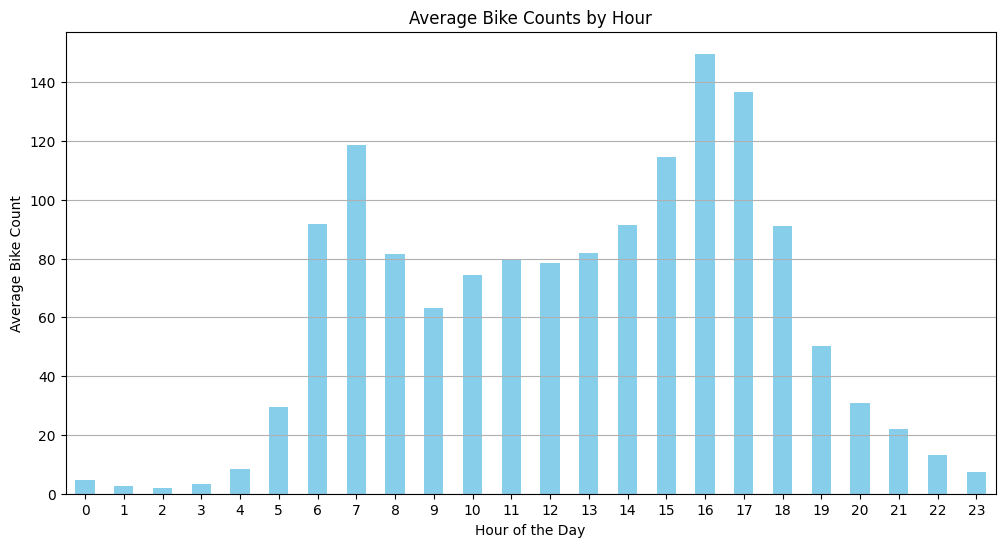

In [6]:
# Aggregate bike counts by hour
hourly_counts = merged_train.groupby('hour')['bike_count'].mean()

# Plotting
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title('Average Bike Counts by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

We see two peaks throughout the day: one around 7am and the other around 4-5pm. Intuitively this looks like it could be due to commutes to work or school, however we will plot hours by weekday to see whether this is the case.

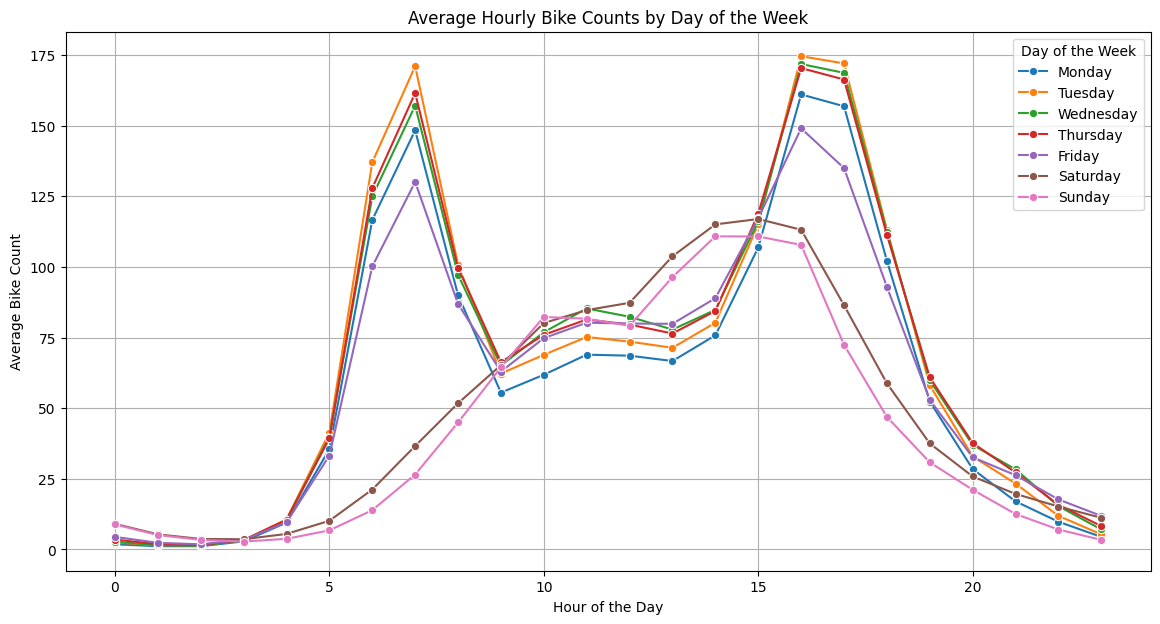

In [12]:
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

hourly_weekday_counts = merged_train.groupby(['weekday', 'hour'])['bike_count'].mean().reset_index()

# Map weekday numbers by name for the plot
hourly_weekday_counts['weekday'] = pd.Categorical(hourly_weekday_counts['weekday'], categories=range(7), ordered=True)
hourly_weekday_counts['weekday'] = hourly_weekday_counts['weekday'].cat.rename_categories(weekday_map)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='hour', y='bike_count', hue='weekday', data=hourly_weekday_counts, palette='tab10', marker='o')
plt.title('Average Hourly Bike Counts by Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Count')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()


Through this plot we can see that the hourly variation, with two sharp peaks around 7:30am and 5:30pm, are clearly driven by weekdays. On weekends the trend is completely different, with a unimque peak and a higher activity around early afternoon. 
Our model will have to account for the strong fluctuations in both hours and weekday vs weekend bike counts.

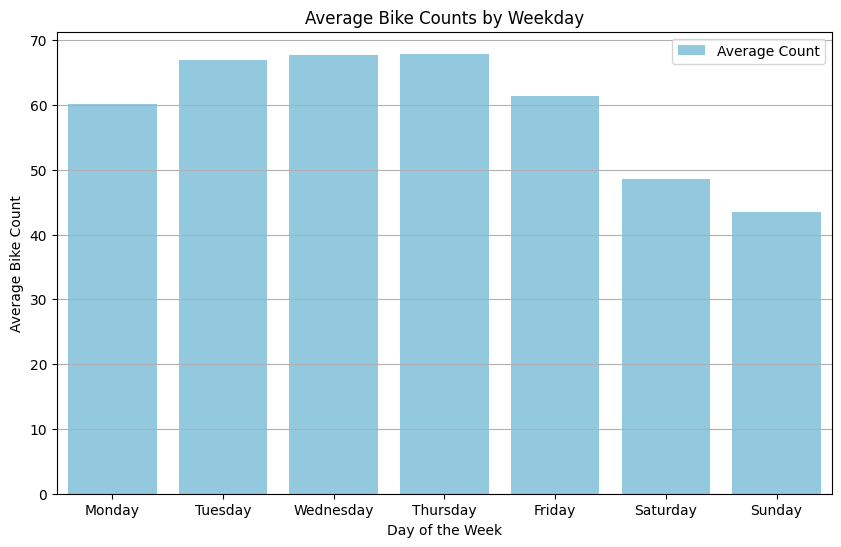

In [ ]:
# Aggregate bike counts by weekday
weekday_counts = merged_train.groupby('weekday')['bike_count'].mean().reset_index()

# Map weekday numbers by name for the plot
weekday_counts['weekday'] = weekday_counts['weekday'].map(weekday_map)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='bike_count', data=weekday_counts, color='skyblue', label='Average Count')
plt.title('Average Bike Counts by Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Average Count')
plt.legend()
plt.grid(axis='y')
plt.show()


We have already seen from the previous plot that weekends seem slightly less busy than weekdays, however this plot also allows us to spot a small variation within the work week, with Mondays and Fridays slightly lower. One explanantion could be that more employees work from home on those days.

/var/folders/v1/r1j96n7d1w57mz0vtk4q7msr0000gn/T/ipykernel_70953/113868835.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_type', y='bike_count', data=day_type_counts, palette='Set3')


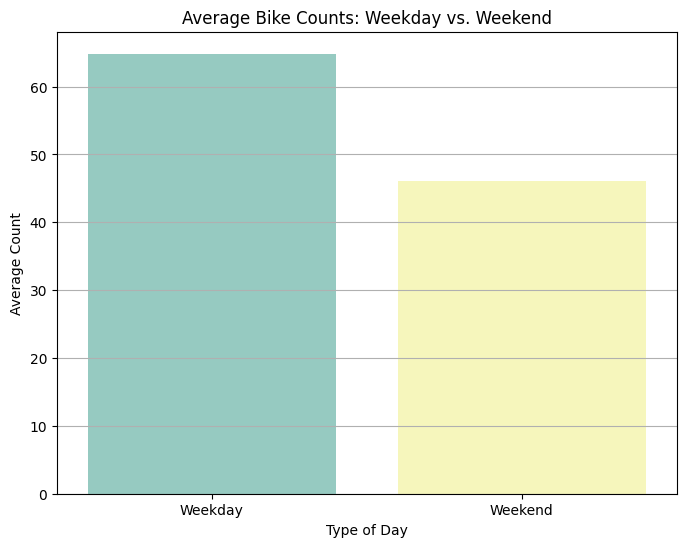

In [ ]:
# classify days by 'Weekday' or 'Weekend'
merged_train['day_type'] = merged_train['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# group data by the type of day and calculate average bike counts
day_type_counts = merged_train.groupby('day_type')['bike_count'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='day_type', y='bike_count', data=day_type_counts, palette='Set3')
plt.title('Average Bike Counts: Weekday vs. Weekend')
plt.xlabel('Type of Day')
plt.ylabel('Average Count')
plt.grid(axis='y')
plt.show()


/var/folders/v1/r1j96n7d1w57mz0vtk4q7msr0000gn/T/ipykernel_70953/2942364437.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='season', y='bike_count', data=season_counts, palette='muted')


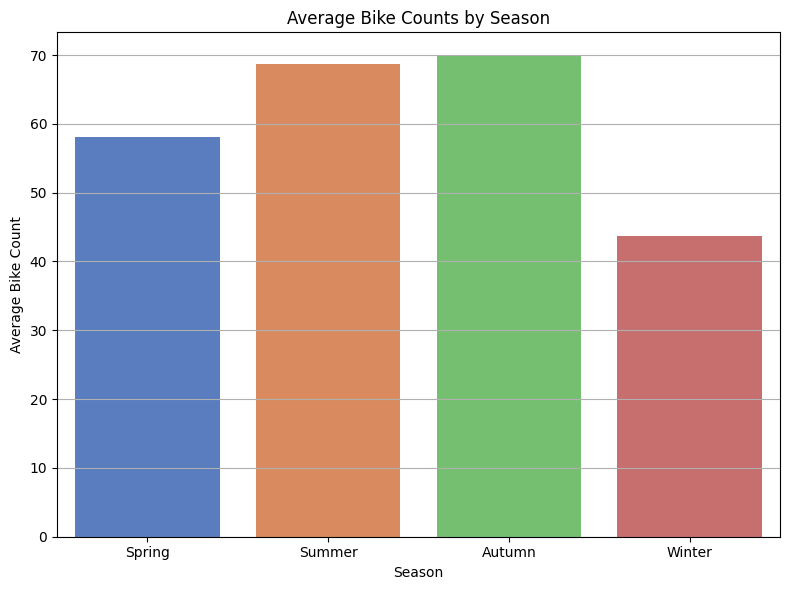

In [ ]:
# map the months to seasons
def map_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the map
merged_train['season'] = merged_train['month'].apply(map_season)

# Group data by season and calculate average bike counts
season_counts = merged_train.groupby('season')['bike_count'].mean().reset_index()

# Ordering the seasons for the plot
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_counts['season'] = pd.Categorical(season_counts['season'], categories=season_order, ordered=True)

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='season', y='bike_count', data=season_counts, palette='muted')
plt.title('Average Bike Counts by Season')
plt.xlabel('Season')
plt.ylabel('Average Count')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()



We also observe some seasonal trends: summer and autumn are the busiest months for bike activity, and winter is the lowest, possibly due to weather conditions. We explore the role of weather conditions more deeply in the next plots. 

#### Weather Trends

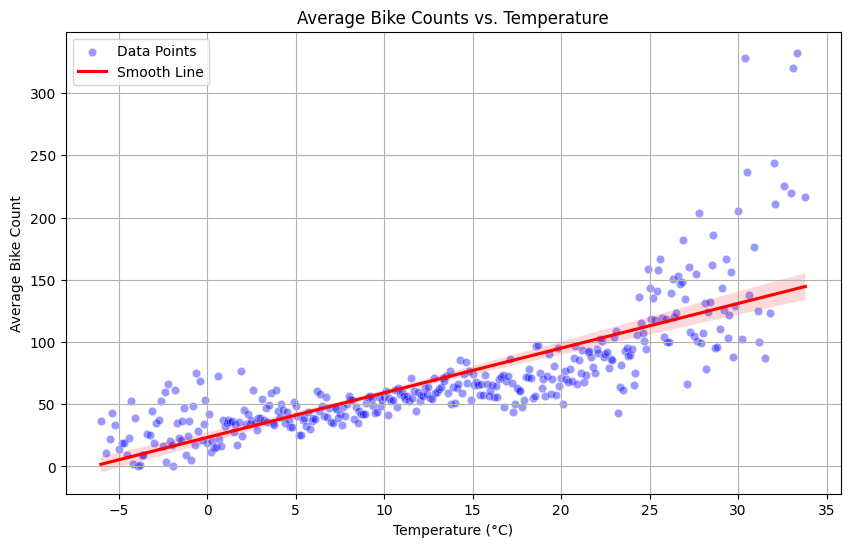

In [9]:
# Group data by temperature
temp_avg_counts = merged_train.groupby('temp')['bike_count'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='bike_count', data=temp_avg_counts, alpha=0.4, color='blue', label='Data Points')
sns.regplot(x='temp', y='bike_count', data=temp_avg_counts, scatter=False, color='red', label='Smooth Line')
plt.title('Average Bike Counts vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.legend()
plt.show()


From this plot we observe a positive correlation between temperature and bike usage. 

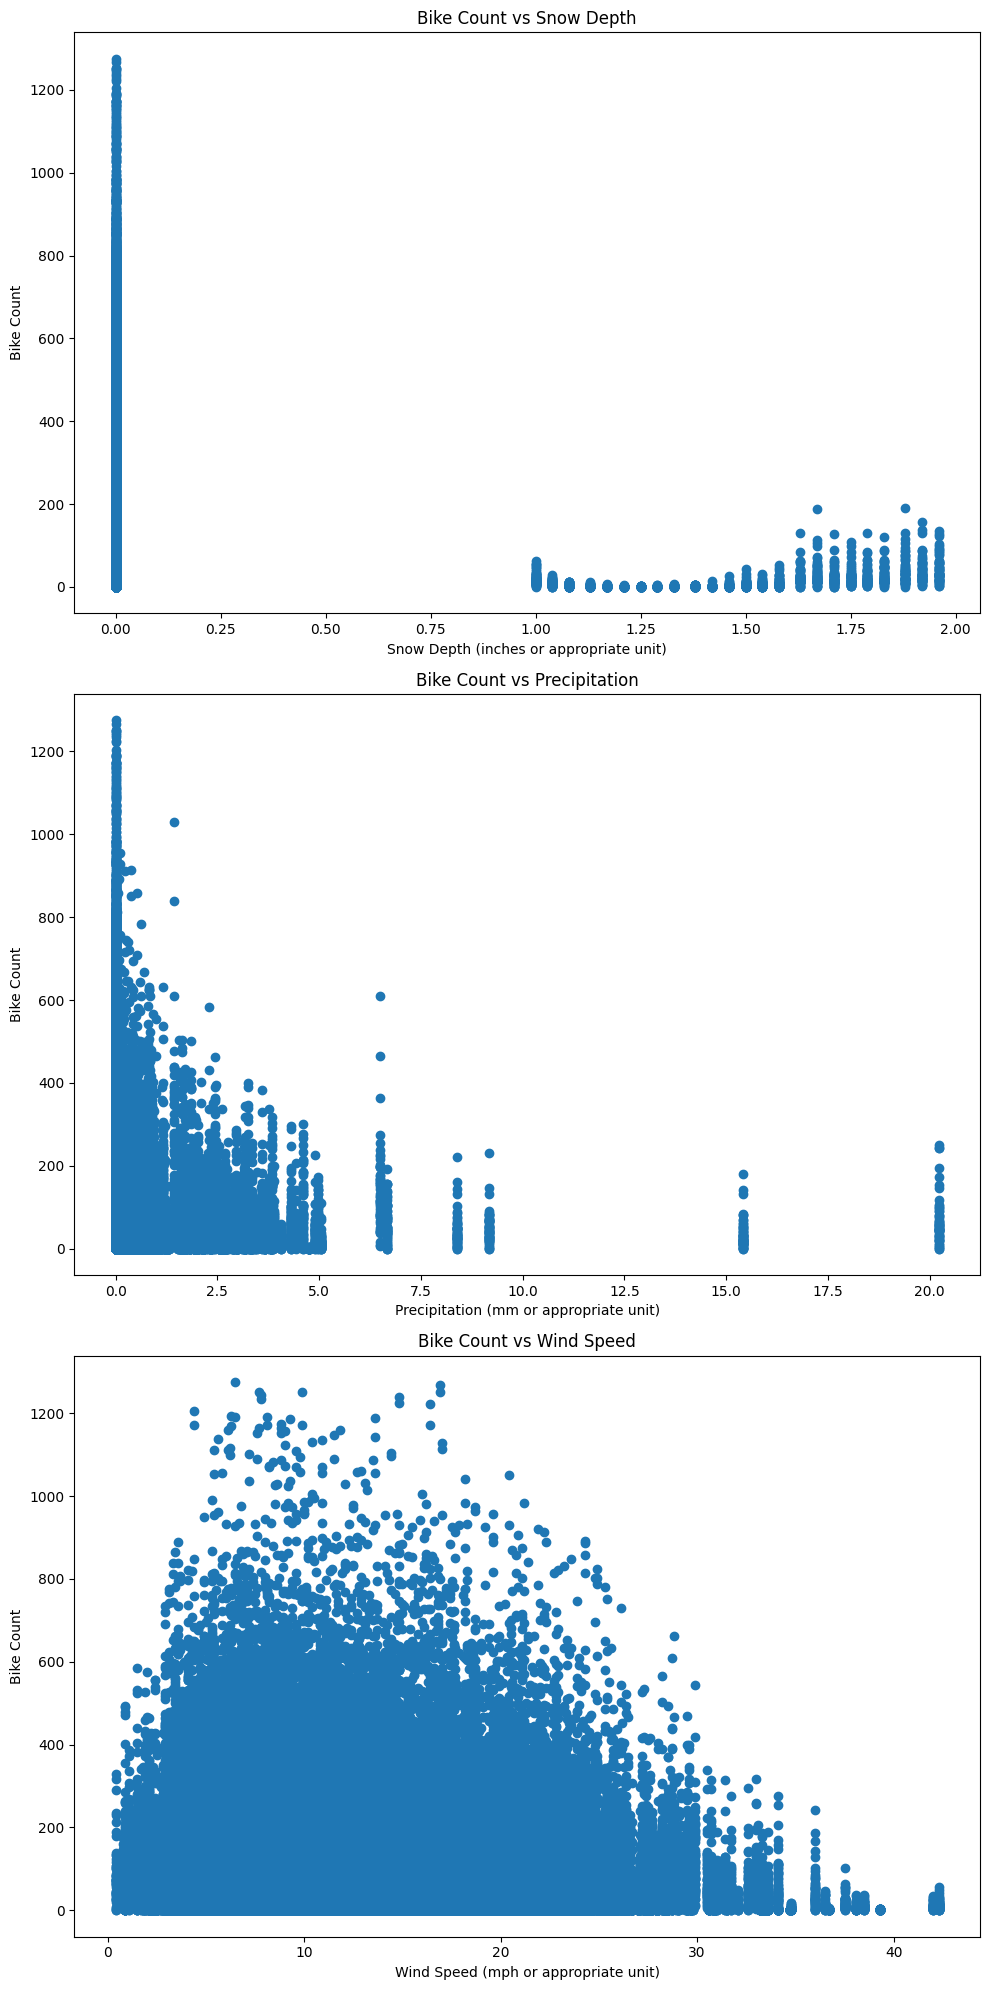

In [11]:
# Creating subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# Scatter plot for Bike Count vs Snow Depth
axes[0].scatter(merged_train['snowdepth'], merged_train['bike_count'])
axes[0].set_title('Bike Count vs Snow Depth')
axes[0].set_xlabel('Snow Depth (inches or appropriate unit)')
axes[0].set_ylabel('Bike Count')

# Scatter plot for Bike Count vs Precipitation
axes[1].scatter(merged_train['precip'], merged_train['bike_count'])
axes[1].set_title('Bike Count vs Precipitation')
axes[1].set_xlabel('Precipitation (mm or appropriate unit)')
axes[1].set_ylabel('Bike Count')

# Scatter plot for Bike Count vs Wind Speed
axes[2].scatter(merged_train['windspeed'], merged_train['bike_count'])
axes[2].set_title('Bike Count vs Wind Speed')
axes[2].set_xlabel('Wind Speed (mph or appropriate unit)')
axes[2].set_ylabel('Bike Count')

# Adjust layout
plt.tight_layout()
plt.show()


/var/folders/v1/r1j96n7d1w57mz0vtk4q7msr0000gn/T/ipykernel_70953/1263113818.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bike_count', y='conditions_grouped', data=conditions_counts_sorted, palette='viridis')


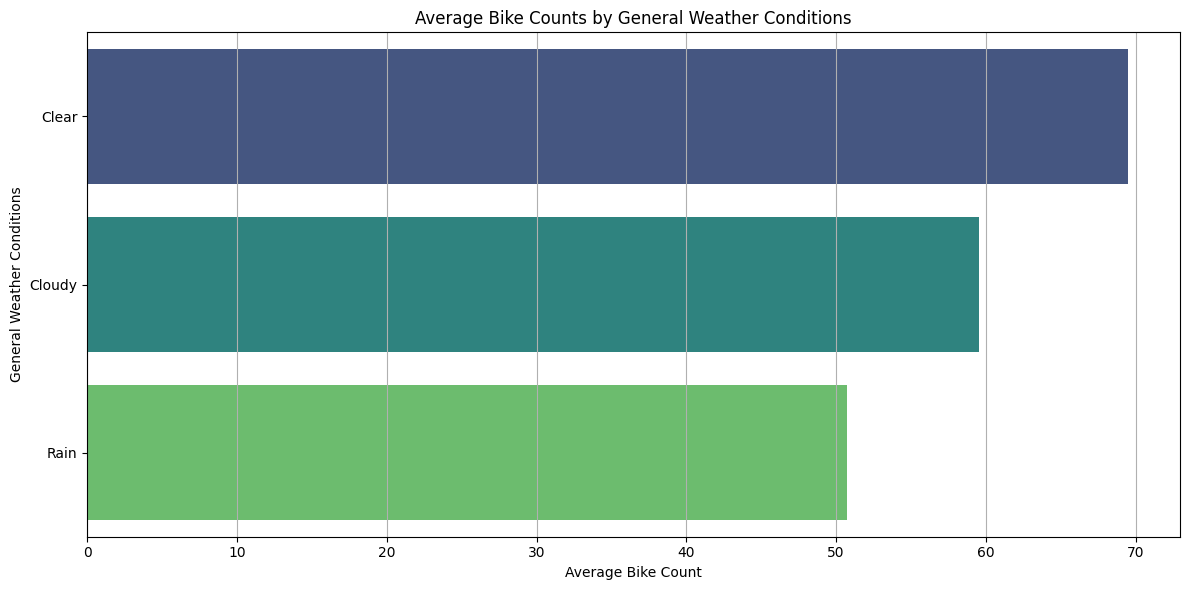

In [ ]:
# Example mapping (adjust based on actual conditions in your data)
conditions_mapping = {
    'Partially cloudy': 'Cloudy',
    'Overcast': 'Cloudy',
    'Clear': 'Clear',
    'Rain': 'Rain',
    'Rain, Partially cloudy': 'Rain',
    'Rain, Overcast': 'Rain'
}

# Apply the mapping
merged_train['conditions_grouped'] = merged_train['conditions'].map(conditions_mapping)

# Group by new category and calculate average
conditions_counts = merged_train.groupby('conditions_grouped')['bike_count'].mean().reset_index()

# Sort the data for better visualization
conditions_counts_sorted = conditions_counts.sort_values(by='bike_count', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='bike_count', y='conditions_grouped', data=conditions_counts_sorted, palette='viridis')
plt.title('Average Bike Counts by General Weather Conditions')
plt.xlabel('Average Bike Count')
plt.ylabel('General Weather Conditions')
plt.grid(axis='x')
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


#### Other Feature Trends

/var/folders/v1/r1j96n7d1w57mz0vtk4q7msr0000gn/T/ipykernel_70953/2708080652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lockdown_comparison', y='bike_count', data=lockdown_comparison_counts, palette='RdBu')


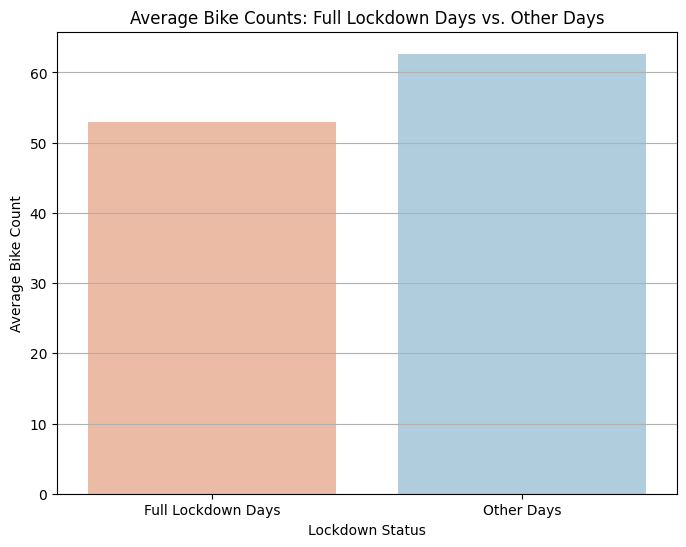

In [ ]:
# create 2 categories: full lockdown days vs other days
merged_train['lockdown_comparison'] = merged_train['full_lockdown'].apply(lambda x: 'Full Lockdown Days' if x == 1 else 'Other Days')

# Group by 'lockdown_comparison' and calculate average
lockdown_comparison_counts = merged_train.groupby('lockdown_comparison')['bike_count'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='lockdown_comparison', y='bike_count', data=lockdown_comparison_counts, palette='RdBu')
plt.title('Average Bike Counts: Full Lockdown Days vs. Other Days')
plt.xlabel('Lockdown Status')
plt.ylabel('Average Bike Count')
plt.grid(axis='y')
plt.show()


We observe slightly higher bike usage when Paris is not in full lockdown. The relation between lockdowns and bike usage may not be straightforward as there may be contradicting effects, for instance bike usage could increase due to people avoiding public transport, while on the other hand more people stay at home which drives bike counts down.

/var/folders/v1/r1j96n7d1w57mz0vtk4q7msr0000gn/T/ipykernel_70953/2678017172.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='bike_count', data=school_holiday_counts, palette='coolwarm')


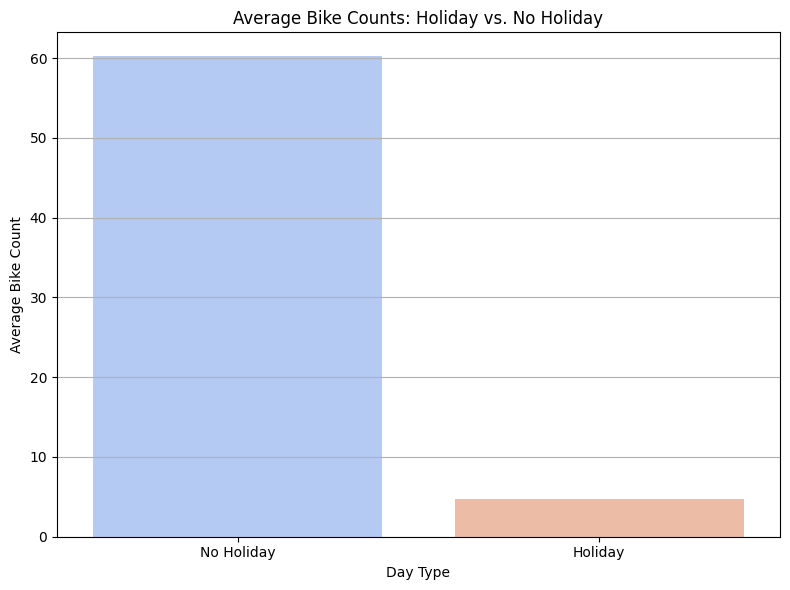

In [ ]:
# Group data by 'is_school_holiday' indicator and calculate average bike counts
school_holiday_counts = merged_train.groupby('is_holiday')['bike_count'].mean().reset_index()

# Map the 'is_school_holiday' values for better readability in the plot
school_holiday_counts['is_holiday'] = school_holiday_counts['is_holiday'].map({0: 'No Holiday', 1: 'Holiday'})

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='is_holiday', y='bike_count', data=school_holiday_counts, palette='coolwarm')
plt.title('Average Bike Counts: Holiday vs. No Holiday')
plt.xlabel('Day Type')
plt.ylabel('Average Bike Count')
plt.grid(axis='y')
plt.show()


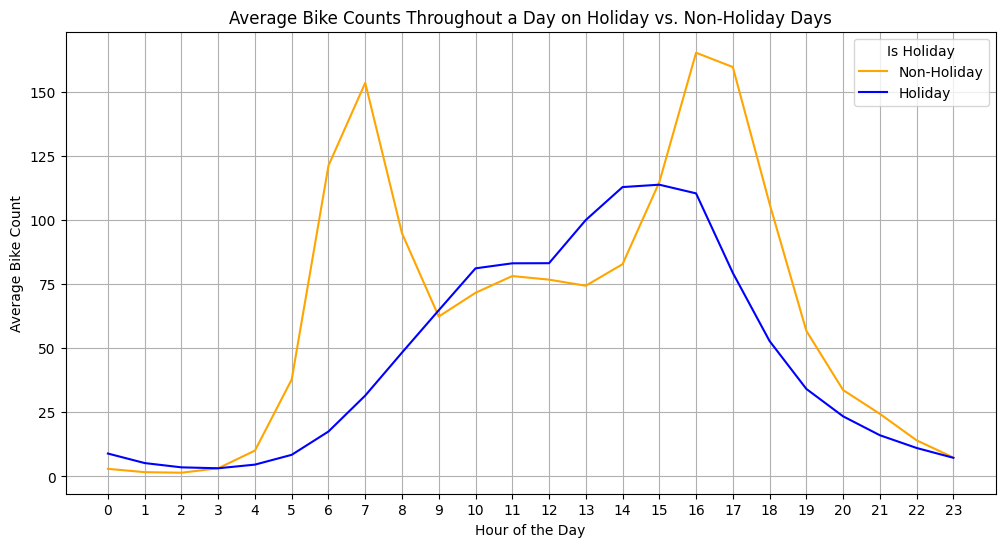

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
palette = {True: "blue", False: "orange"}

sns.lineplot(data=grouped_data, x='hour', y='bike_count', hue='is_holiday', palette=palette)
plt.title('Average Bike Counts Throughout a Day on Holiday vs. Non-Holiday Days')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Count')
plt.xticks(range(0, 24))
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'], handles=[
    plt.Line2D([], [], color="orange", label='Non-Holiday'),
    plt.Line2D([], [], color="blue", label='Holiday')
])

plt.grid(True)
plt.show()


As we can see, holiday vs non-holiday days have a similar effect on hourly patterns in bike usage as weekends, with a steady increase in the afternoon.

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a new map centered around Paris
paris_coords = [48.8566, 2.3522]
map = folium.Map(location=paris_coords, zoom_start=12)

# Prepare data for HeatMap
# The data for the HeatMap needs to be a list of [lat, lon, weight], where weight is the bike count.
heat_data = [[row['latitude'], row['longitude'], row['bike_count']] for index, row in lat_lon_counts.iterrows()]

# Add HeatMap to the map
HeatMap(heat_data).add_to(map)

map


The heatmap shows that there are several heavily frequented bike stations, notably in the 1st-2nd Arrondissements.

#### EDA Takeaways
The main takeaways from these graphs are the features which might drive bike usage:
- Hours and day of the week
- Holidays vs no holidays
- Weather

Sth about how we construct our model based on this ...

### Linear Regression

In [ ]:
# drop the date column
X_merged_train = merged_train.drop(columns=['bike_count', 'log_bike_count', 'date', 'conditions'])
X_merged_test = merged_test.drop(columns=['bike_count', 'log_bike_count', 'date', 'conditions'])

X_merged_train.to_csv('X_merged_train.csv', index=False)
X_merged_test.to_csv('X_merged_test.csv', index=False)

In [ ]:
X_merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   coordinates        51440 non-null  category
 1   latitude           51440 non-null  float64 
 2   longitude          51440 non-null  float64 
 3   temp               51440 non-null  float64 
 4   feelslike          51440 non-null  float64 
 5   humidity           51440 non-null  float64 
 6   precip             51440 non-null  float64 
 7   precipprob         51440 non-null  int64   
 8   snow               51440 non-null  float64 
 9   snowdepth          51440 non-null  float64 
 10  windgust           51384 non-null  float64 
 11  windspeed          51440 non-null  float64 
 12  cloudcover         51440 non-null  float64 
 13  visibility         51440 non-null  float64 
 14  is_holiday         51440 non-null  int64   
 15  is_strike          51440 non-null  int64   
 16  full

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Function to extract date-related features
def encode_dates(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['weekday'] = df['date'].dt.weekday
        df['hour'] = df['date'].dt.hour
        df = df.drop(columns=['date'])
    return df

# Make sure 'date' column exists before calling encode_dates
if 'date' in X_merged_train.columns:
    X_merged_train = encode_dates(X_merged_train)

if 'date' in X_merged_test.columns:
    X_merged_test = encode_dates(X_merged_test)

# Define numerical features to be scaled
numerical_features = ['latitude', 'longitude', 'temp', 'humidity', 
                      'precip', 'snowdepth', 'windgust', 
                      'windspeed', 'cloudcover', 'visibility', 'is_strike', 'full_lockdown', 'is_holiday']

categorical_features = ['hour','month', 'day', 'weekday', 'year']

# Preprocessor for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, 
                               learning_rate = 0.2, max_depth = 8, alpha = 10, n_estimators = 10))
])

# Fit the pipeline on the training data
pipeline.fit(X_merged_train, Y_merged_train)

# Predictions
y_train_pred = pipeline.predict(X_merged_train)
y_test_pred = pipeline.predict(X_merged_test)



In [ ]:
## Predict on the training data for evaluation
y_train_pred = pipeline.predict(X_merged_train)

# Calculate RMSE for the training data
train_rmse = np.sqrt(mean_squared_error(Y_merged_train, y_train_pred))
print(f"Train RMSE: {train_rmse}")

Train RMSE: 1.1559658135749364


In [ ]:
# Predict on the test data
y_pred = pipeline.predict(X_merged_test)

# Prepare the submission
results = pd.DataFrame({
    'Id': np.arange(y_pred.shape[0]),
    'log_bike_count': y_pred
})

# Save the results to a CSV file
results.to_csv("submission.csv", index=False)